# <span style="color:orange">Quality Data Analysis - Project Work [FULL PROJECT] </span>
## Team 1

### Course Details:
- Academic Year: 2023-2024

### Project Details:
- Title: [ENTER PROJECT TITLE HERE]

### Team Members:
- Abylaikhan Orynbassar
- Giulia Mezzadri
- Federico Angelo Mor
- Federica Rena

### Instructor:
- Panagiotis Tsiamyrtzis

# Instructions
- This is a template notebook for the project work.
- Please fill in the details above (team members, instructor, etc.)
## PHASE 1 - Report structure
Please use the following sections for your project report:
- **Introduction** [max 3500 characters including spaces]
    - Recap the project work framework and objective
    - Briefly summarize the overall methodology you used to model and analyse your data
    - Briefly summarize the state-of-the-art you analysed to support your study (if any).
- **Assumptions and preliminary data analysis** [max 5000 characters including spaces]
    - Clearly state and motivate all the assumptions your proposed methodology relies on; present and discuss any preliminary data analysis and visualization you applied on the data.
- **Proposed methodology** [max 10000 characters including spaces]
    - Synthetically describe, motivate and critically discuss your proposed statistical process monitoring approach. 
- **Results** [max 10000 characters including spaces]
    - Synthetically presents and discuss the results of your statistical process monitoring design. 

## PHASE 2 - Report structure
Please use the following sections for your project report:
- **Preliminary data analysis** [max 5000 characters including spaces]
    - Synthetically describe and discuss any preliminary data analysis and visualization applied on the new dataset.
- **Test of your proposed approach on new data** [max 5000 characters including spaces]
    - Synthetically presents and discuss the results you got applying to the new data your previously designed statistical process monitoring approach.
- **Discussion** [max 5000 characters including spaces]
    - Critically discuss your results In this Section you can also propose possible ways to tune or revise your previously designed method to enhance its defect detection performance. 

You can add code cells to any of the above sections to show your code or display images. Each block of code should be accompanied by a brief description of what it does (not counted in characters limits).

## Submission
- Name your notebook as `teamXX.ipynb` where `XX` is your team number.
- Submit your notebook together with the Dataframe as a ZIP file on Webeep by the deadline. The ZIP file name must clearly state the "TEAM NUMBER".

# PHASE 1 ------------------------------

# Introduction
<!-- i am adding numbers to titles so is tidier i think -->

<!-- - Recap the project work framework and objective
- Briefly summarize the overall methodology you used to model and analyse your data
- Briefly summarize the state-of-the-art you analysed to support your study (if any). -->

The overall procedure can be summarized as follows:
- Dataset creation and refinement [section 2](#Assumptions-and-preliminary-data-analysis)
- Variables definition and selection [section 3](#Proposed-methodology)
- Control charting [section 3](#Proposed-methodology)

where each point will be further detailed in the next sections (as linked trough the square brackets).

# Assumptions and preliminary data analysis
<!-- - Clearly state and motivate all the assumptions your proposed methodology relies on; present and discuss any preliminary data analysis and visualization you applied on the data. -->
Assumptions: later we check normality, but at the beginning we did not check anything special.

### Data analysis
After the image acquisition, we ran the provided python script to generate all the images statistics (e.g. Area, Perimeter, Eccentricity, etc). At that stage the unique "key" which identified each object was the combination of the Image Name and Position variables, so we decided to merge them into a single ID using this simple function (of which the inverse function, to recover Image Name and Position given the created ID, could also be easily defined):

```python
def img_info_to_part_id(imgname, location):
	imgid = int(re.search(r"img(\d+)\.bmp", imgname).group(1))
	if location == "top_left":
		return (imgid - 1) * 4
	elif location == "bottom_left":
		return (imgid - 1) * 4 + 1
	elif location == "top_right":
		return (imgid - 1) * 4 + 2
	elif location == "bottom_right":
		return (imgid - 1) * 4 + 3

# img_info_to_part_id("img01.bmp", "top_left")     -> 0
# img_info_to_part_id("img01.bmp", "bottom_left")  -> 1
# img_info_to_part_id("img01.bmp", "top_right")    -> 2
# img_info_to_part_id("img01.bmp", "bottom_right") -> 3
# img_info_to_part_id("img02.bmp", "top_left")     -> 4
# img_info_to_part_id("img02.bmp", "bottom_left")  -> 5
# img_info_to_part_id("img02.bmp", "top_right")    -> 6
# img_info_to_part_id("img02.bmp", "bottom_right") -> 7
```

The script also provided a segmentation part which automatically isolated the single objects, by cropping a region around them. However, soon after we decided to implement our own code to do the segmentation, since we thought that to compare more fairly the images statistics we needed a "common ground" on which they should be computed.

That is, we thought that we should firstly center the objects and crop them around their main outer edge, and only then compute their statistics. Otherwise we believed that the values some possibly relevant variable, such as the Perimeter or the Axes Lengths, would have been altered by the wrong orientation of the original images. In this way instead we brough all the object images to the same context (perfect centering alignement and perfect cropping), so that the later comparison of their characteristics would be more accurate.\
To do this we wrote the following function

```python
def rotate_and_crop(img, rect):
	# get params
	center, size, angle = rect[0], rect[1], rect[2]
	# angle correction
	if angle > 45: 
		angle = angle - 90
	
	center, size = tuple(map(int, center)), tuple(map(int, size))
	# get row and col num in img
	height, width = img.shape[0], img.shape[1]
	# rotation matrix
	M = cv2.getRotationMatrix2D(center, angle, 1)
	# apply rotation
	img_rot = cv2.warpAffine(img, M, (width, height))
	# crop it
	img_crop = cv2.getRectSubPix(img_rot, size, center)
	return img_crop, img_rot
```

which we applied in the final procedure of the new dataset definition.\
This procedure involved the following steps:
- load (and read as grayscale) the original cropped images generated with the python script
- binarize them using Otsu threshold
- apply the Canny filter to detect the edges
- select the largest edge to compute the parameters for rotation and cropping
- apply rotate and crop function

We can see the results of these operations in the following figure.

<!-- 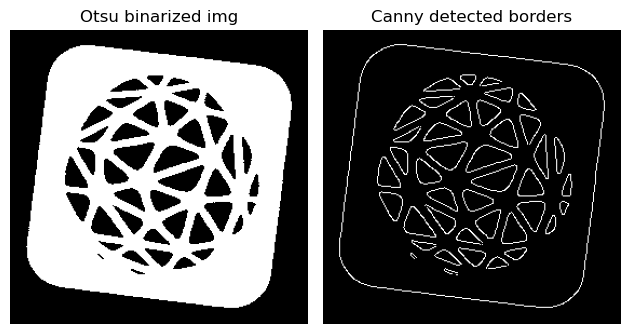 -->
<!-- 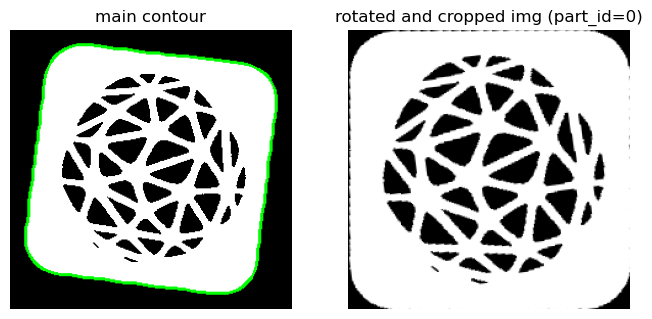 -->
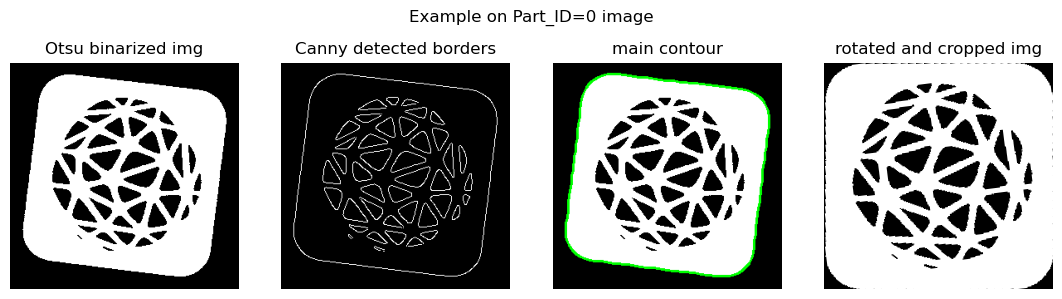
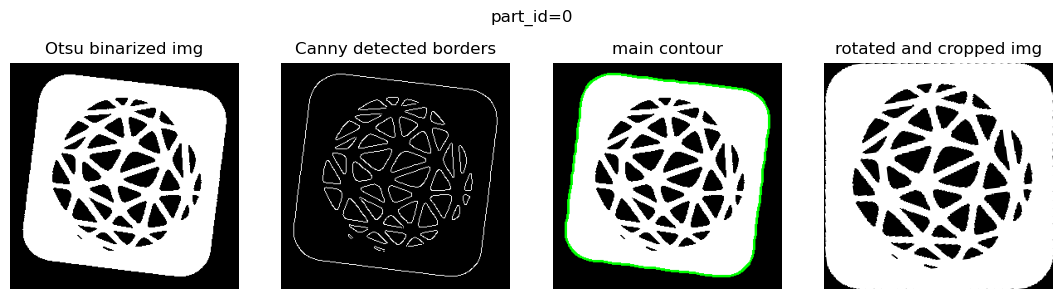

In this way we got to the definition of a new dataset. We also noticed that this refinement was useful to make the statistics extraction more effective. Indeed we found several cases in which after the refinement we got more precise estimates of the number of voids, as if the centering and cropping procedure, which morally induced also a "zooming", evidenced better the voids regions. For example in the next image we see how we moved from 44 to 42 voids, since in the new labeling we have a single region 16 rather than two in the old case, which we believe are incorrectly separated, as well as no region corresponding to label 44 in the old one, which instead was just probably a random white pixel.

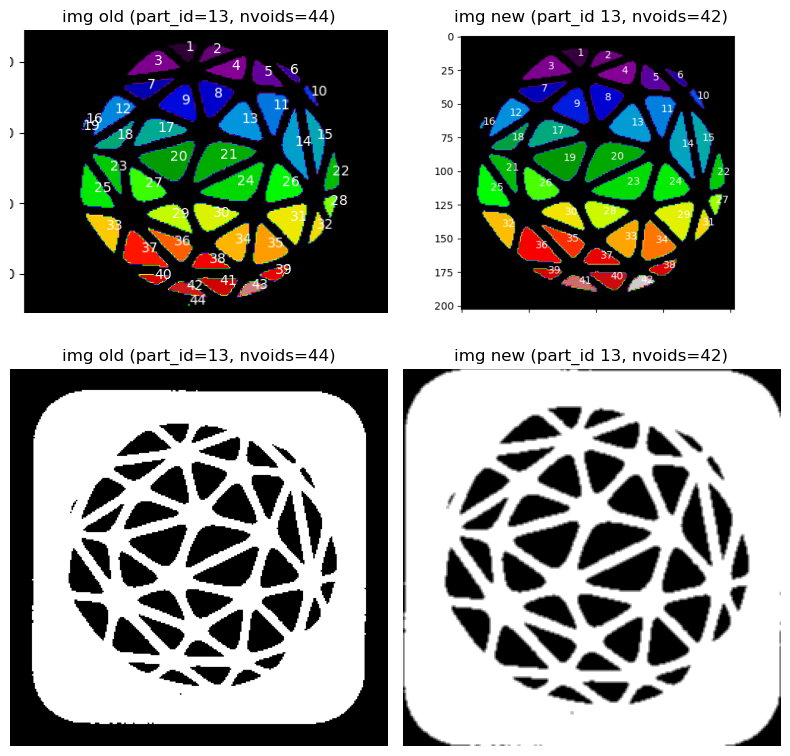

Moreover, we created some new variables to enrich the description of our data. Here we provide a brief description of them:
- the already mentioned Part_ID variable, to uniquely determine each object 
- Num_voids, to count how many voids each object had
- ecc

# Proposed methodology

# Results

# References (if any)

# PHASE 2 -----------------------------

# Preliminary data analysis

# Test of your proposed approach on new data

# Discussion